### Spark ML

- ML 과정을 간소화하기 위해서 추정자, 변환자, 평가자라는 개념을 도입했음.
- 객체를 결합시켜서 **파이프라인** 을 구성할 수 있고,각 객체에 필요한 ML parameter들을 일관되게 적용시킬 수 있다.
- 입출력 데이터롤 **dateframe** 을 이용한다.
- Dateframe API로 가공한 데이터를 그대로 ML용 파이프라인의 입력 데이터로 활용할 수 있다.

#### Spark Pipeline
- Transformer
    - 한 데이터셋을 다른 데이터셋으로 변환한다.
    - 스파크 ML 모델도 데이터셋에 예측 결과를 더함 (변환 작업) 그래서 변환자에 해당함.
    - **transform** 이라는 핵심 메서드. Dataframe을 필수 인수로 받고, 선택 인수로 매개변수 집합을 받음.
- Estimator
    - 주어진 데이터셋을 학습해서 변환자를 생성한다.
    - 추정자의 결과 -> 변환자 (회귀 모델)
    - 핵심 메서드인 fit : Dataframe을 인수로 받고, 선택 인수로 매개변수 집합을 받음.
- Evaluator
    - 모델 성능의 평가자.
    - RMSE, R^2 등이 있다.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# Pyspark SQL.

# Spark의 Dataset & Dataframe API 를 쓰기 위한 엔트리포인트.
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
# Dataframe들에 대해서 수행할 수 있는 built-in function들의 집합.
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

### Pipeline
파이프라인 = Estimator & Transformer들의 집합.
`Pipeline.fit()` 호출 시 각 stage들이 순서대로 실행된다.
- 스테이지가 Estimator일 경우 : 입력 데이터셋에 대해서 `fit`을 하고, estimator의 결과로 나온 transformer가 입력 데이터셋을 transform 한다.
- 스테이지가 Transformer일 경우 : `Transformer.transform()` 메서드를 통해서 다음 스테이지를 위한 데이터셋을 생성한다.

`Pipeline`으로부터 나온 모델을 `PipelineModel` 이라고 한다.

*Pipeline은 모델을 도출하기 위한
estimator이고, PipelineModel은 Pipeline의 결과로 얻어지는 Transformer(모델)* 이다

In [7]:
from pyspark.ml import Pipeline
# VectorAssembler : 여러 column들을 vector column으로 모아주는 transformer
# StringIndexer : 라벨들에 대한 string column들을 ML column으로 변환시켜줌.
# QuantileDiscretizer : 연속적인 feature들을 가진 column을 가지고 범주화시켜줌.
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer

# MultiClass Classification을 위한 Evaluator.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [9]:
spark = SparkSession.builder\
                    .appName("Play with Pyspark ML with Titanic Data!")\
                    .getOrCreate()

In [10]:
# spark.read : DataframeReader 객체를 반환.
df = spark.read.csv('./titanic.csv', header = True, inferSchema = True)
# limit : 결과를 해당 개수만큼만 제한.
# Dataframe의 내용을 pandas.dataframe으로 반환.
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [11]:
pandas_df = df.toPandas()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/

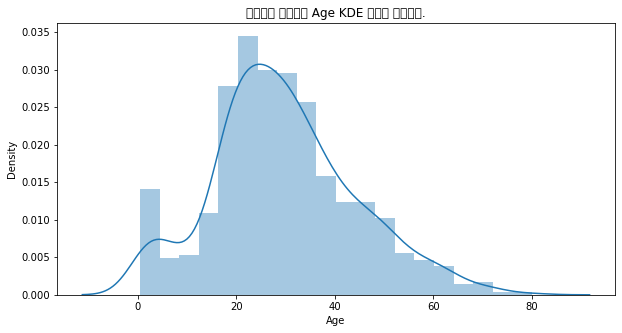

In [13]:
plt.figure(figsize  = (10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포를 알아보자.")
sns.distplot(pandas_df['Age'])
plt.show()

### Pyspark로 결측치 체크하고, 파생변수 생성해보기

In [17]:
from pyspark.sql.functions import isnan, count

# column에 대해서
null_columns = [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
# df.select() => 주어진 column들? 을 이용해서 새로운 데이터프레임을 반환한다.
df.select(null_columns).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [20]:
new_df = df.drop('Cabin')
# withColumn : 매개변수로 넘긴 정보를 가지고 새로운 column을 만들어서 기존 df에 합체시킨 df를 반환.
new_df = new_df.withColumn("Initial", regexp_extract(col("Name"), "([A-Za-z]+)\.", 1))
new_df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



In [21]:
new_df = new_df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [22]:
new_df.groupby("Initial").avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [24]:
df = new_df

In [25]:
# 승객의 유형별로 나이 결측치를 대체하여 사용.
df = df.withColumn('Age',
                  when((df['Initial'] == 'Miss') & (df['Age'].isNull()),
                      22).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Other') & (df['Age'].isNull()),
                      46).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Master') & (df['Age'].isNull()),
                      5).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mr') & (df['Age'].isNull()),
                      33).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mrs') & (df['Age'].isNull()),
                      36).otherwise(df['Age']))

In [26]:
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [27]:
df = df.na.fill({"Embarked": "S"})
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



### FEATURE ENGINEERING

In [28]:
df = df.withColumn("Family_Size", col("SibSp") + col("Parch"))
df = df.withColumn("Alone", lit(0))
df = df.withColumn("Alone", when(col("Family_Size") == 0, 1).otherwise(col("Alone")) )

In [31]:
# Label Enconding
convert_cols = ["Sex", "Embarked", "Initial"]

indexer = [StringIndexer(inputCol = col, outputCol = col + '_index').fit(df) for col in convert_cols]

In [33]:
# 확인해보면 각 컬럼별로 고유의 index들이 생성되어 있는 것을 확인할 수 있다.
for i in indexer :
    print(i)
    print('-' * 80)

StringIndexerModel: uid=StringIndexer_bb29f395e665, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_d16e07aeebca, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_ed30a1052b0d, handleInvalid=error
--------------------------------------------------------------------------------


In [35]:
# indexer를 이용해서 df를 변환시키는 파이프라인 생성.
pipeline = Pipeline(stages = indexer)

In [36]:
# df에 대해서 fit 연산을 수행해서 transformer를 생성하고,
model = pipeline.fit(df)
# 해당 transformer를 이용해서 라벨 엔코딩을 실행한다.
df = model.transform(df)

In [37]:
df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|      0.0|           0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|      1.0|           1.0|          2.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|  

In [41]:
df = df.drop(*['PassengerId', "Name", "Ticket", "Cabin", "Embarked", "Sex", "Initial"])

In [42]:
df.limit(3).show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+



최종적으로 남은 Feature들을 Vector로 변환시켜서 모델에 입력시키기.

In [43]:
feature_assembler = VectorAssembler(inputCols = df.columns[1:], outputCol = 'features')
feature_vector = feature_assembler.transform(df)

In [44]:
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


## Train set, Test set 만들기.

In [45]:
titanic_df = feature_vector.select(['features', 'Survived'])

In [54]:
(train_df, test_df) = titanic_df.randomSplit([0.8, 0.2], seed = 11)

### 학습시키기

In [55]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression().setFeaturesCol("features").setLabelCol("Survived")
lrModel = Pipeline(stages=[lr]).fit(train_df)

### 결과 확인

In [56]:
train_pred = lrModel.transform(train_df).toPandas()['prediction']
train_label = train_df.toPandas()['Survived']
test_pred = lrModel.transform(test_df).toPandas()['prediction']
test_label = test_df.toPandas()['Survived']

In [57]:
from sklearn.metrics import accuracy_score

print(f"Train Score: {100 * accuracy_score(train_pred, train_label):.2f}%")
print(f"Test Score: {100 * accuracy_score(test_pred, test_label):.2f}%")

Train Score: 80.80%
Test Score: 87.23%
